# Modelling and Predicting Employee Attrition #

In [32]:
library(tidyverse)
library(broom)
library(GGally)
library(car)
library(glmnet)
library(caret)
library(repr)
library(infer)
library(gridExtra)
library(pROC)
library(boot)
install.packages("ROSE")
options(warn = -1)
library(ROSE)
library(ggplot2)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## STAT 301: Group Project

#### Names: Justin Bourdon, Nour Abdelfattah, Nav Thukral, Sean Lin

#### Student Numbers: 13755392, 97158414, 20761581, 79391983

## Introduction

The HR Analytics dataset mainly focuses on data related to employees characteristics and job descriptors. The dataset contains 1470 observations, and for each observation, we have 35 variables, as shown below (Age, Attrition, BusinessTravel, etc.). Attrition is a commonly noted challenge faced by many companies and corporations, where an employee leaves the organization and is not replaced for a long time. To better understand patterns of attrition, we can use machine learning models, like classification, in order to predict potential attrition cases. This allows managers to better prepare and generate strategies that promote employee retention, ensuring the organization's activities continue running in a smooth manner. 

As for the question we plan on answering, we looked through the variables given and determined that the three seemingly relevant variables for predicting attrition were `JobSatisfaction`, `YearsAtCompany`, and `MonthlyIncome`. Along with our binary response variable `Attrition`, our question becomes:

**"Do job satisfaction, monthly income, and total working years at a company affect employee attrition, and can we predict which employees are more likely to leave the company based on these variables?"**

We chose these 3 variables because our EDA shows promising variability across the different classes of attrition (see visualizations in EDA). In general, a higher proportion of attrition is seen amongst employees with lower incomes, employees who have worked at the company for a shorter amount of time as well as those who report the lowest ratings of Job Satisfaction. In fact, research that has conducted predictive modelling using the same dataset illustrated that in terms of feature importance, `MonthlyIncome` was found to be the most highly related factor with attrition (Fallucchi et al. 2020). A similar study also predicting employee attrition using machine learning also found that attrition was positively correlated with `MonthlyIncome` and `YearsAtCompany` (Bhuva & Srivastava,2018). Research has also shown links between `JobSatisfaction` and employee behaviors, with findings that indicate that employee motivation and Job Satisfaction revealed statsitically significant direct paths to employee retention (De Sousa Sabbagha, Ladimo and Martins, 2018). From this, we inferred that if employees are satisfied with their jobs, they are less likely to leave the organization. After examining both the visualizations from the EDA and the supporting literature, some of which are replications of our analysis, we decided that these 3 variables are the most promising predictors to implement into a logistic regression model, as a way of predicting employee `Attrition`.

In [42]:
# Download latest version
path = "HR-Employee-Attrition 2.csv"

raw_data=read_csv(path)

head(raw_data)

Rows: 1470 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): Attrition, BusinessTravel, Department, EducationField, Gender, Job...
dbl (26): Age, DailyRate, DistanceFromHome, Education, EmployeeCount, Employ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


## Methods and Results ## 

### 1) Exploratory Data Analysis

#### Dataset Summary

The table below illustrates all of the variables in our dataset.

| Variable                | Description                                                    | Type               |
|-------------------------|----------------------------------------------------------------|--------------------|
| Age                     | Age of the employee                                           | Continuous        |
| Attrition               | Employee attrition, whether or not they leave the company     | Binary |
| BusinessTravel          | How frequently an employee travels for business purposes       | Categorical       |
| DailyRate               | Daily wage of an employee                                     | Continuous        |
| Department              | Employee's department                                           | Categorical       |
| DistanceFromHome        | Distance from home to office in KM's                          | Continuous        |
| Education               | Qualification of employee                                     | Continuous        |
| EducationField          | Stream of Education                                           | Categorical       |
| EmployeeCount           | Employee count (1 employee per observation, so max = 1)      | Continuous        |
| EmployeeNumber          | Employee number                                               | Continuous        |
| EnvironmentSatisfaction | Level of employee satisfaction with environment               |Categorical/Ordinal |
| Gender                  | Gender of employee                                            | Binary |
| HourlyRate              | Employee hourly rate                                          | Continuous        |
| JobInvolvement          | Job involvement                                               | Categorical/Ordinal|
| JobLevel                | Level of Job                                                  | Continuous        |
| JobRole                 | Job role of an employee                                       | Categorical       |
| JobSatisfaction         | If employee is satisfied?                                     | Categorical/Ordinal |
| MaritalStatus           | If employee is married or not?                                | Categorical       |
| MonthlyIncome           | Income of an employee per month                               | Continuous        |
| MonthlyRate             | Monthly rate of an employee                                   | Continuous        |
| NumCompaniesWorked      | Number of companies worked for                                | Continuous        |
| Over18                  | If they are over the age of 18                                | Binary |
| OverTime                | Does employee work overtime?                                  | Binary |
| PercentSalaryHike       | Salary hike in percentage (%)                                 | Continuous        |
| PerformanceRating       | Performance rate                                              | Continuous        |
| RelationshipSatisfaction| Relationship satisfaction                                     | Categorical/Ordinal |
| StandardHours           | Per week standard work hours                                  | Continuous        |
| StockOptionLevel        | Company stock option level                                    | Continuous        |
| TotalWorkingYears       | Total years working                                           | Continuous        |
| TrainingTimesLastYear   | Training time in the last year                                | Continuous        |
| WorkLifeBalance         | Work-life balance                                             | Categorical/Ordinal  |
| YearsAtCompany          | Total years at current company                                | Continuous        |
| YearsInCurrentRole      | Total years in current role                                   | Continuous        |
| YearsSinceLastPromotion | Years since last promotion                                    | Continuous        |
| YearsWithCurrManager    | Years worked under current manager                            | Continuous        |

Before we start visualizing our variables of interest, we can clean our data and closely examine the types of variables our dataset contains. Just by a scan of the dataset, we see three columns that are redundant, as they only have one value across all the datapoints. These columns are `EmployeeCount`, `StandardHours`, and `Over18`. 

In [43]:
data <- raw_data %>% select(-EmployeeCount, -StandardHours, -Over18)

In [44]:
#checking dataset dimensions
shape <- dim(data)
shape

[1] 1470   32

Next, we can look at our categorical variables and see what different categories they contain

In [45]:
data %>%
  select_if(is.character) %>%
  map(unique)

$Attrition
[1] "Yes" "No" 

$BusinessTravel
[1] "Travel_Rarely"     "Travel_Frequently" "Non-Travel"       

$Department
[1] "Sales"                  "Research & Development" "Human Resources"       

$EducationField
[1] "Life Sciences"    "Other"            "Medical"          "Marketing"       
[5] "Technical Degree" "Human Resources" 

$Gender
[1] "Female" "Male"  

$JobRole
[1] "Sales Executive"           "Research Scientist"       
[3] "Laboratory Technician"     "Manufacturing Director"   
[5] "Healthcare Representative" "Manager"                  
[7] "Sales Representative"      "Research Director"        
[9] "Human Resources"          

$MaritalStatus
[1] "Single"   "Married"  "Divorced"

$OverTime
[1] "Yes" "No"

As seen by the code below, there are no missing values, which makes our job of cleaning values a lot easier

In [46]:
colSums(is.na(data))

Age                Attrition           BusinessTravel 
                       0                        0                        0 
               DailyRate               Department         DistanceFromHome 
                       0                        0                        0 
               Education           EducationField           EmployeeNumber 
                       0                        0                        0 
 EnvironmentSatisfaction                   Gender               HourlyRate 
                       0                        0                        0 
          JobInvolvement                 JobLevel                  JobRole 
                       0                        0                        0 
         JobSatisfaction            MaritalStatus            MonthlyIncome 
                       0                        0                        0 
             MonthlyRate       NumCompaniesWorked                 OverTime 
                       0                        0                        0 
       PercentSalaryHike        PerformanceRating RelationshipSatisfaction 
                       0                        0                        0 
        StockOptionLevel        TotalWorkingYears    TrainingTimesLastYear 
                       0                        0                        0 
         WorkLifeBalance           YearsAtCompany       YearsInCurrentRole 
                       0                        0                        0 
 YearsSinceLastPromotion     YearsWithCurrManager 
                       0                        0

With the data cleaned, we can obtain summary statistics for our 4 variables of interest. Since our question is only focused on the variables `JobSatisfaction`, `YearsAtCompany`, and `MonthlyIncome`, we can select only these variables in our data

In [47]:
#Main developer: Sean Lin 
data <- data %>%
    select(
        # response variable
        Attrition,
        # explanatory variables
        JobSatisfaction,
        YearsAtCompany,
        MonthlyIncome)

head(data)

Attrition,JobSatisfaction,YearsAtCompany,MonthlyIncome
<chr>,<dbl>,<dbl>,<dbl>
Yes,4,6,5993
No,2,10,5130
Yes,3,0,2090
No,3,8,2909
No,2,2,3468
No,4,7,3068


In [10]:
#Main developer: Nour Abdelfattah

# visualizing summary statistics for our 4 desired variables (3 predictors and 1 response)

numerical_stats <- data %>%
    select_if(is.numeric) %>%
    gather(factor_key = TRUE, key = 'variable', value = 'value') %>%
    group_by(variable) %>%
    summarise(mean = mean(value),
              sd = sd(value), 
              max = max(value), 
              min = min(value)) %>%
    mutate_if(is.numeric, round, 2)

numerical_stats

categorical_stats <- data %>%
    select_if(is.character) %>% 
    gather(key = "variable", value = "level") %>%
    group_by(variable, level) %>%
    summarise(count = n(), .groups = 'drop') %>%
    group_by(variable) %>%
    mutate(percentage = round((count / sum(count)) * 100, 2))

categorical_stats


variable,mean,sd,max,min
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
JobSatisfaction,2.73,1.10,4,1
YearsAtCompany,7.01,6.13,40,0
MonthlyIncome,6502.93,4707.96,19999,1009


variable,level,count,percentage
<chr>,<chr>,<int>,<dbl>
Attrition,No,1233,83.88
Attrition,Yes,237,16.12


We can see in the table above that there is a class imbalance, with the majority class being `Attrition = No`.

**Important NOTE**: `JobSatisfaction is an ordinal variable so will be used as a factor in our logistic regression model

#### Visualizations

To better understand the relationship between the explanatory variables (`MonthlyIncome`, `YearsAtCompany`, `JobSatisfaction`) and the response variable (`Attrition`), we performed the following exploratory data analysis:

1. Visualized the relationship between `Attrition` and each explanatory variable using bar plots and box plots.
2. Explored pairwise relationships between variables with `ggpairs`.

These visualizations provide insights into potential patterns and associations that could influence attrition.

####  Years at the Company by Attrition
The first bar plot indicates that employees with fewer years at the company are more likely to leave (higher attrition rates). Attrition seems to decrease as tenure increases, suggesting longer-tenured employees are more likely to stay.

We can also visualize the plot using a fill position, and we notice that from 0-20 years at the company, there seems to be a trend that suggests that the longer someone works at a company, the less likely they are to leave. As we reach the higher end however, we notice some inconsistent values, with the chart illustarting a very high proportion of attrition, which most likely stems from the lack of data points that have YearsAtCompany >25 and/or correlations with other extraneous circumstances that might be affecting attrition i.e. retirement. 

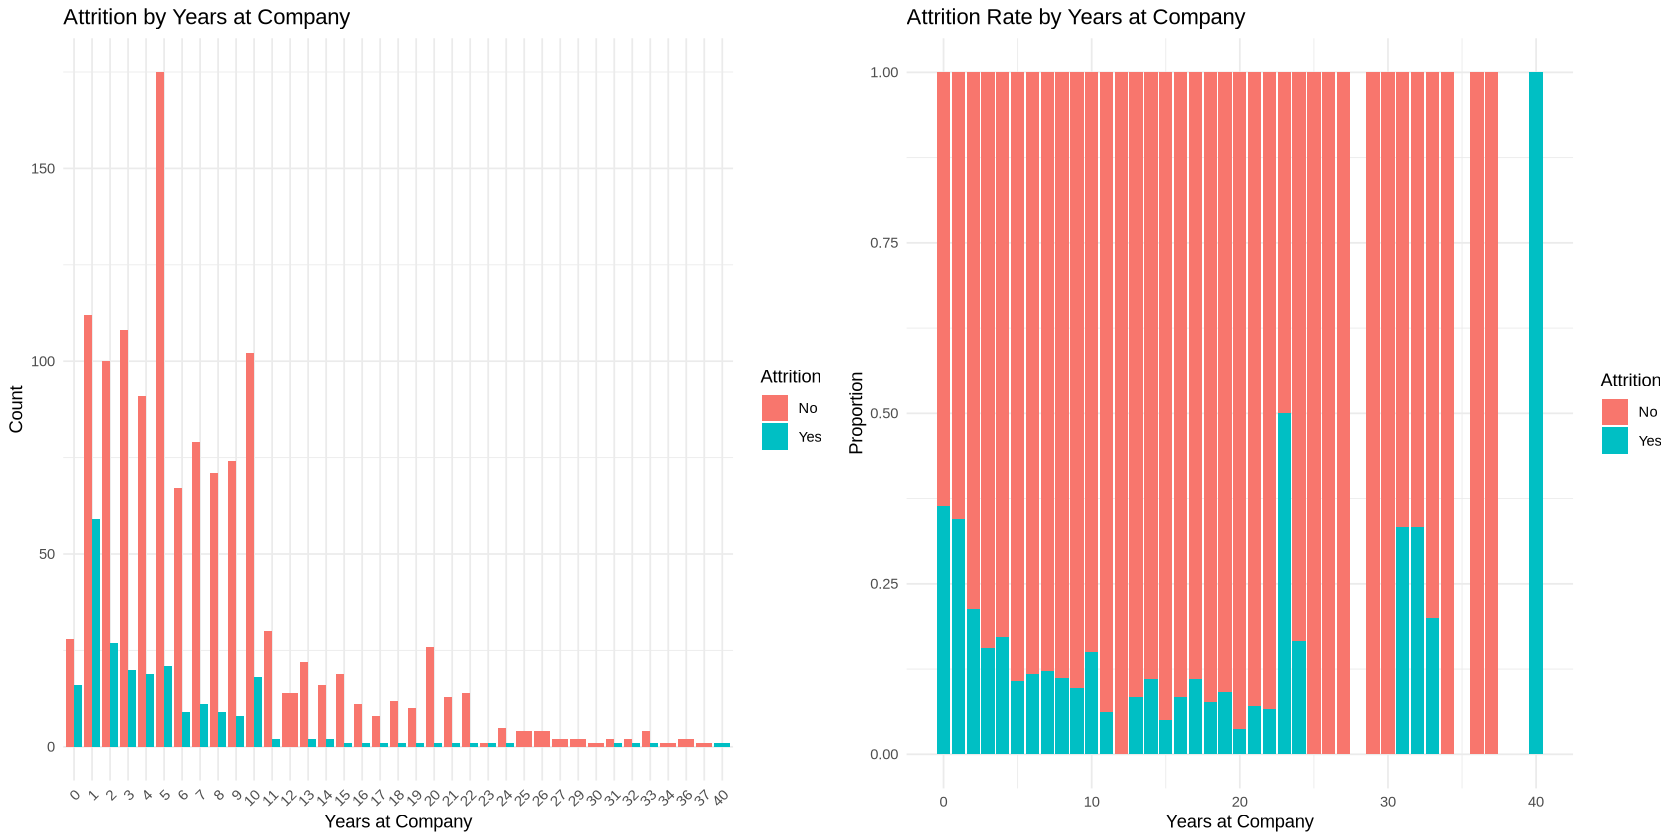

In [48]:
#Main developer: Nav Thukral
options(repr.plot.width = 14, repr.plot.height = 7)

# Bar plot (dodge) of Attrition by YearsAtCompany
years_1 <- ggplot(data, aes(x = factor(YearsAtCompany), fill = Attrition)) +
  geom_bar(position = "dodge") +
  labs(title = "Attrition by Years at Company", x = "Years at Company", y = "Count", fill = "Attrition") +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

#Main developer: Sean Lin
# bar plot (fill) of attrition by years at company
years_2 <- ggplot(data, aes(x = YearsAtCompany, fill = Attrition)) +
    geom_bar(position = "fill") + 
    labs(
        title = "Attrition Rate by Years at Company",
        x = "Years at Company",
        y = "Proportion"
    ) +
    theme_minimal()

grid.arrange(years_1, years_2, ncol = 2, widths = c(1,1))

### Monthly Income by Attrition

The boxplot illustrates the relationship between monthly income and employee attrition. Employees who left the company (`Attrition = Yes`) tend to have a lower median monthly income compared to those who stayed (`Attrition = No`). This suggests that lower income may be a contributing factor to attrition, with a noticeable disparity between the two groups. Outliers are present in both categories, indicating that some employees with higher incomes still left the organization, highlighting the potential influence of additional factors.

We can also revisualize the relationship with a histogram. We notice that although there a lot more data points at the lower end, we still notice that as the monthly income increases, there is a decrease in attrition rates on average. 

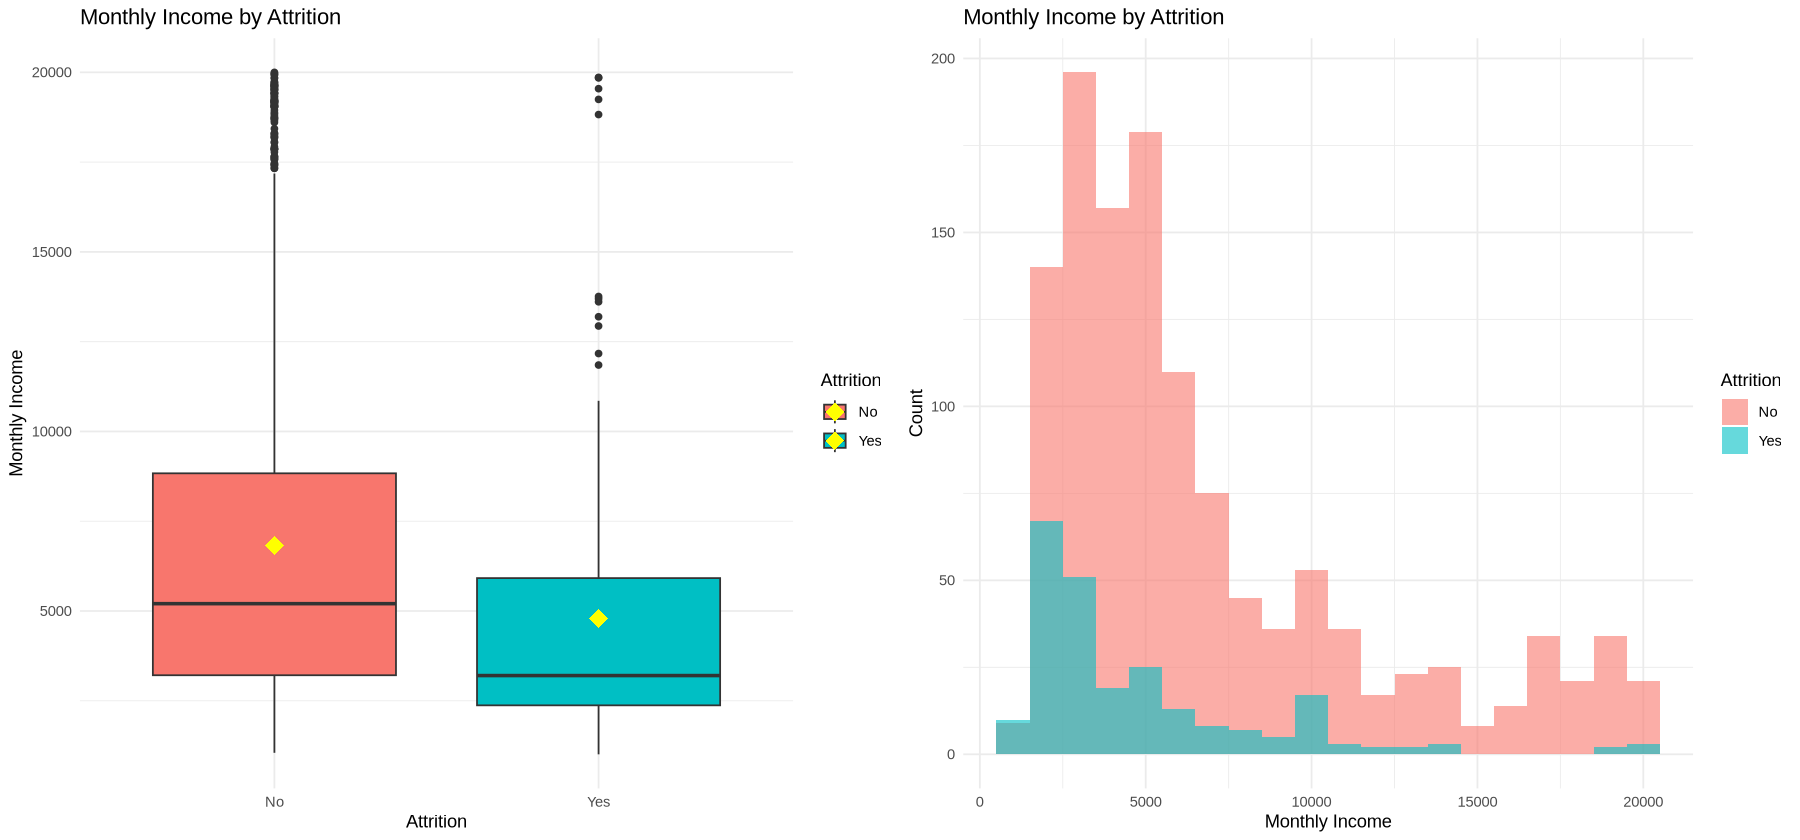

In [49]:
options(repr.plot.width = 15, repr.plot.height = 7)

#Main developer: Nav Thukral 
#Contributor: Nour Abdelfattah
# Boxplot of MonthlyIncome by Attrition
income_1 <- ggplot(data, aes(x = Attrition, y = MonthlyIncome, fill = Attrition)) +
  geom_boxplot() +
  labs(title = "Monthly Income by Attrition", x = "Attrition", y = "Monthly Income") +
  theme_minimal() + 
  stat_summary(aes(Attrition, MonthlyIncome, fill = Attrition),
    fun = mean, colour = "yellow", geom = "point",
    shape = 18 , size = 5
  )

#Main developer: Sean Lin
# histogram of monthly income by attrition
income_2 <- ggplot(data, aes(x = MonthlyIncome, fill = Attrition)) +
  geom_histogram(position = "identity", binwidth = 1000, alpha=0.6) +
  labs(
    title = "Monthly Income by Attrition",
    x = "Monthly Income",
    y = "Count"
  ) +
  theme_minimal()

grid.arrange(income_1, income_2, ncol = 2, widths = c(1,1))

### Job Satisfaction by Attrition

The bar plot below displays the relationship between job satisfaction and attrition. The bar plot is made with the position "fill" so that we can see the proportional distribution of the job satisfaction level with attrition classes. The "yes" value of attrition is shown in blue and "no" is shown in red. As we can see, as the value of job satisfaction increases, the proportion of attrition decreases by a noticable amount. There seems to be a linear relationship between the variables.

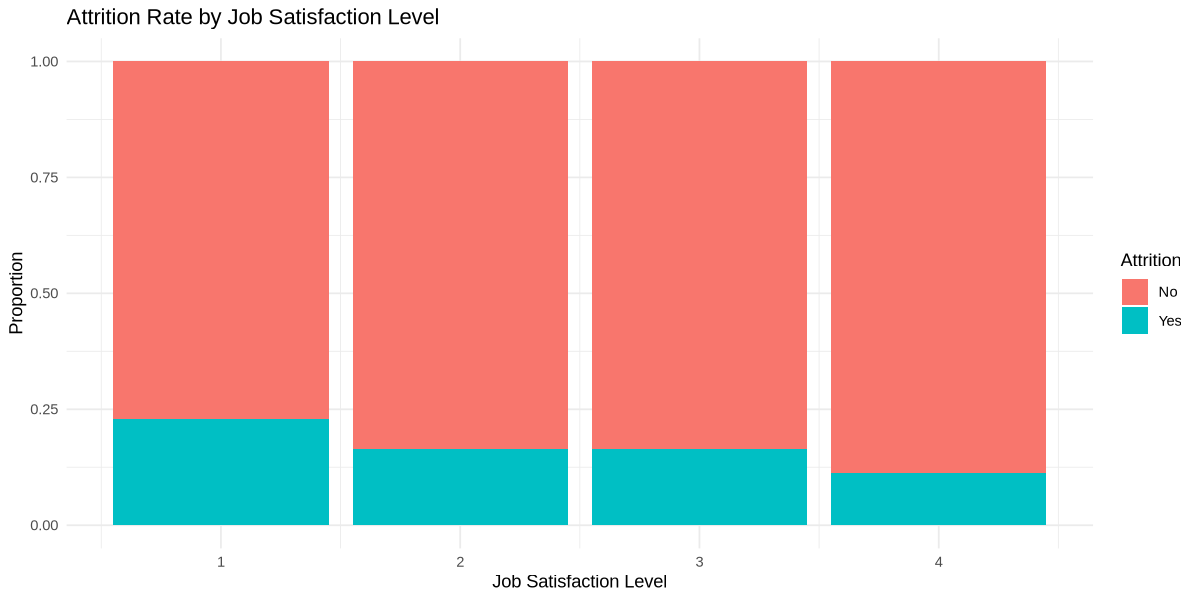

In [50]:
#Main developer: Sean Lin
options(repr.plot.width = 10, repr.plot.height = 5)

# barplot of job satisfaction by attrition
ggplot(data, aes(x = JobSatisfaction, fill = Attrition)) +
    geom_bar(position = "fill") + 
    labs(
        title = "Attrition Rate by Job Satisfaction Level",
        x = "Job Satisfaction Level",
        y = "Proportion"
    ) +
    theme_minimal()

### Pairwise Relationships Between Variables of Interest

The pairwise plot provides an overview of the relationships between `MonthlyIncome`, `YearsAtCompany`, and `Attrition`. From the visualizations:
- A moderate positive correlation (0.514) is observed between `MonthlyIncome` and `YearsAtCompany`, suggesting that longer tenure is generally associated with higher income.
- Employees with `Attrition = No` have slightly higher median values for both `MonthlyIncome` and `YearsAtCompany`, as shown in the box plots.
- The distributions and scatterplots highlight differences between employees who stayed (`Attrition = No`) and those who left (`Attrition = Yes`), offering insights into the predictors of attrition.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


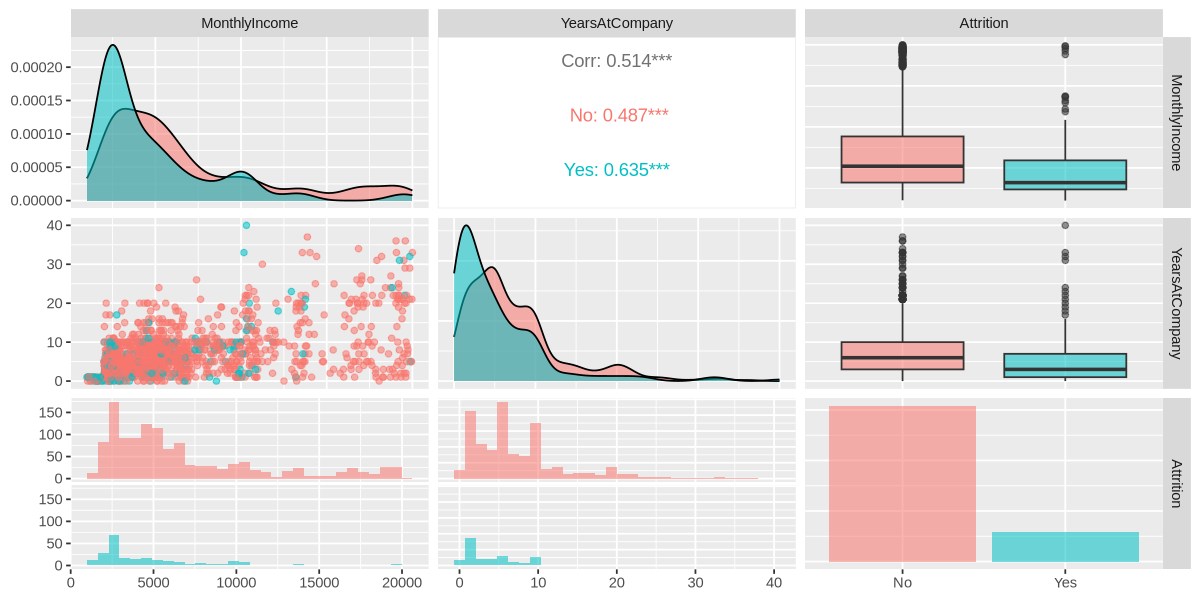

In [51]:
#Main developer: Nav Thukral 
options(repr.plot.width = 10, repr.plot.height = 5)

# Select relevant columns for pairwise relationships
eda_data <- data %>% 
  select(MonthlyIncome, YearsAtCompany, Attrition)

# Create pairwise plot
ggpairs(eda_data, aes(color = Attrition, alpha = 0.7))



### 2) Methods: Plan ###

Our plan is to use Ordinary logistic regression to generate a predictive model that predicts `Attrition` classes on new observations (test set). Since, we have 2 continuous predictors (Monthly income and Years at company), 1 categorical predictor (Job Satisfaction) and a binary response variable (Attrition = Yes/No), logistic regression is the most appropriate model to implement. We selected these 3 variables out of the 35 in the dataset because after visualizing their distributions across attrition levels (see EDA), `YearsAtCompany`, `MonthlyIncome` and `JobSatisfaction` seem to be the most promising. Distributions of other variables from the dataset showed a lack of variability across attrition levels (these were done in the first 2 individual assignments). Research examining employee attrition patterns and those that have also implemented different predictive models also confirm the importance of these features in predicting attrition (Fallucchi et al. 2020, Bhuva & Srivastava,2018, De Sousa Sabbagha, Ladimo and Martins, 2018). A lot of the other variables are also irrelevant for our analysis. e.g. `EmployeeNumber` and `EmployeeCount`, as they do not provide any informative value on Attrition. 

Using a train/test split, the model will be fitted on the training data and then its performance will be evaluated on the test data. Since there is a high class imbalance, with 83% 'No' cases and 16% 'Yes' cases of attrition (see table in EDA), we also decided to oversample the minority class (Yes) in the training data to ensure the model is sensitive enough to attrition cases. The test set remained unaltered, to represent real-world data. We used AUC as the metric for our model's performance and specificity, which measures its performance on the negative class of Attrition (our majority class).

In [52]:
#Main developers: Nour Abdelfattah
attrition_data <- data

attrition_data <- attrition_data %>%
  mutate(
    JobSatisfaction = as.factor(JobSatisfaction),
    Attrition = if_else(Attrition == "Yes", 1, 0) 
  )

table(attrition_data$Attrition)


   0    1 
1233  237 

In [53]:
#Main developers: Nour Abdelfattah and Justin Bourdon 
set.seed(123)

attrition_data <- attrition_data %>%
  mutate(ID = row_number())

#training set
attrition_data_train <- 
    attrition_data %>% 
    slice_sample(prop = 0.70)

#test set 
attrition_data_test <- 
    attrition_data %>% 
    anti_join(attrition_data_train, by = "ID")

cat("Training Set Class Distribution:\n")
print(table(attrition_data_train$Attrition))

cat("\nTest Set Class Distribution:\n")
print(table(attrition_data_test$Attrition))

#oversampling minority class in training set to adjust class imbalance issue
balanced_data_train <- ovun.sample(
    Attrition ~ ., 
    data = attrition_data_train, 
    method = "both", 
    p = 0.3 # Proportion of the minority class you (30%)
)$data

cat("\nBalanced Training Set Class Distribution:\n")
table(balanced_data_train$Attrition)

attrition_data_train <- balanced_data_train  %>% select(-ID)
attrition_data_test <- attrition_data_test  %>% select(-ID)

Training Set Class Distribution:

  0   1 
867 162 

Test Set Class Distribution:

  0   1 
366  75 

Balanced Training Set Class Distribution:



  0   1 
726 303 

We can see in the output above that by oversampling, the balanced training data has a better dsitribution of Yes and No cases compared to the original training set.

In [54]:
# Main developers: Nour Abdelfattah
# Contributor: Justin Bourdon 
#additive model 
logistic_model <- 
    glm(
        formula = Attrition ~ MonthlyIncome + YearsAtCompany + JobSatisfaction,
        data = attrition_data_train,
        family = binomial)

misclassification_rate <- function(y, p.hat){
    y_hat <- round(p.hat, 0)
    error_rate <- mean(abs(y - y_hat))
    return(error_rate)
}

# 10-fold cross-validation
cv_results <- cv.glm(
    data = attrition_data_train, 
    glmfit = logistic_model,
    K = 10, cost = misclassification_rate
)

# cross-validated error
print(cv_results$delta[1])  # Cross-validation errors


[1] 0.271137


Despite applying oversampling on the training data, the cross validation error rate still remains quite high, with a value of 0.27. This estimates the out of sample error rate (the error rate of data never seen by our model). A 27% misclassification rate suggests that the model correctly predicts 73% of the cases on unseen data.

In [55]:
# Main developers: Nour Abdelfattah and Justin Bourdon 

#predict attrition class on test set
pred_probs <- 
  predict(logistic_model, newdata = attrition_data_test, type = "response")

pred_classes <- ifelse(pred_probs >= 0.5, 1, 0)

#illustarte results in confusion matrix
attrition_data_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(pred_classes),
    reference = as.factor(attrition_data_test$Attrition),
    positive = '1'
)


attrition_data_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 345  65
         1  21  10
                                          
               Accuracy : 0.805           
                 95% CI : (0.7649, 0.8409)
    No Information Rate : 0.8299          
    P-Value [Acc > NIR] : 0.9255          
                                          
                  Kappa : 0.0991          
                                          
 Mcnemar's Test P-Value : 3.538e-06       
                                          
            Sensitivity : 0.13333         
            Specificity : 0.94262         
         Pos Pred Value : 0.32258         
         Neg Pred Value : 0.84146         
             Prevalence : 0.17007         
         Detection Rate : 0.02268         
   Detection Prevalence : 0.07029         
      Balanced Accuracy : 0.53798         
                                          
       'Positive' Class : 1               
                              

The confusion matrix illustrates an accuracy of 0.805 (81%) on the test data. However, this metric is not representative in our case because of class imbalance (despite oversampling the training data to increase sensitivity). We can see this because there is a high number of false positives, given by a sensitivity score of 0.133 (13.3%). This means that although the majority class is being predicted correctly, the minority class is being predicted quite poorly.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC Value: 0.62 


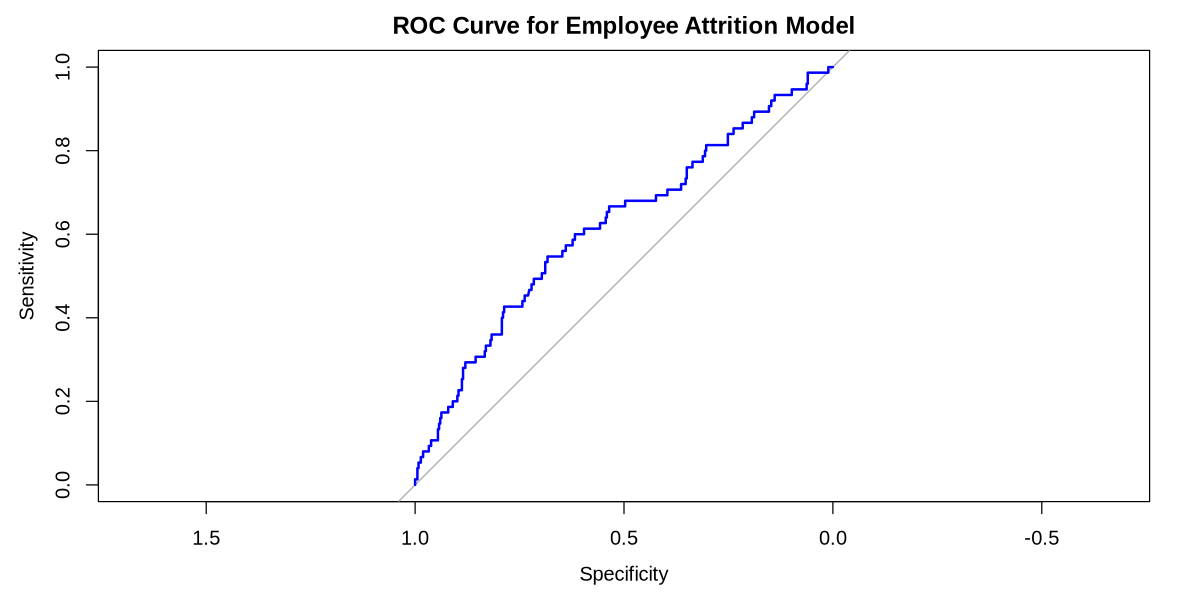

In [57]:
#Main developers: Nav Thukral
# Generate the ROC curve
roc_curve <- roc(response = attrition_data_test$Attrition, 
                 predictor = pred_probs)

# Plot the ROC curve
plot(roc_curve, 
     main = "ROC Curve for Employee Attrition Model", 
     col = "blue", 
     lwd = 2)

# Add AUC to the plot
auc_value <- auc(roc_curve)
cat("AUC Value:", round(auc_value, 2), "\n")


An AUC score of **0.62** indicates the model has some ability to discriminate between the positive and negative classes, but the performance is poor and only slightly better than random guessing.

Since our majority class = 0 (No attrition), another metric we can use to assess model performance is: **Specificity**

We know that the total number of real failures in the test set = 366 and the model successfully predicted 345 (see confusion matrix). **This means that our specificity score is:** 345/366 = 0.943.

Thus, our model shows **94.3%** accuracy for predicting the majority class (No attrition).

## Discussion ##

Using predictive modelling, our goal in this project was to answer the following question:

**"Do job satisfaction, monthly income, and total working years at a company affect employee attrition, and can we predict which employees are more likely to leave the company based on these variables?"**

After having analyzed our dataset, fitted a logistic regression model relating attrition and our three predictor variables and tested the performance of our model on test data, we can now attempt to answer this question.

Firstly, we have found that our model has an estimated accuracy of 0.805, which appears to be quite high, but it is important to remember that a good accuracy rate is highly dependent on the distribution of the data and in our case the testing data was heavily imbalanced toward no attrition with 83% of observation of no attrition and the remaining 17% of observation with attrition. Despite oversampling the minority class in the training data, this imbalance still remained in our test data. So, our accuracy might not be the result is likely not representative of our model's efficiency, which is why other metrics were used to assess the skill of our logistic regression model as the no information rate would result in an accuracy of 0.8299, this would mean a p-value of 0.9255 which provides very little evidence that our model presents skill.

The sensitivity of our model is 0.133333 which is quite low especially if the goal of our model is to help managers prepare for possible attrition, our model would rarely allow the manager to accurately prepare for attrition. The specificity on the other hand indicates a high capacity of the model to accurately predict no attrition when no attrition is indeed observed with a rate of 0.94262.

Finally, with an AUC of 0.62, this indicates that our model performs somewhat better than a random classifier, but it is very far from being a perfect classifier.

Those results are not what we expected to find out, we expected the three variables selected to produce a model that would skillfully distinguish between attrition and no attrition, especially since the literature supports the use of these 3 variables. Perhaps attrition is a complicated phenomenon that might not be easily explained by the variables found in our dataset or at least not by only three variables.

Our model could potentially be improved by adding more variables as predictors in our model that would explain more of the variance in the data and could potentially improve the skill of the logistic model. Perhaps LASSO regression could be applied to all relevant variables in our dataset and the variables correlated with attrition could be kept to produce a more accurate model.

Our analysis open the door to questions such as: What other variables can improve the skill of a logistic regression model in the prediction of attrition? Are HR analytics data the only variables that should be looked at or should other types of variables such as health data or other socioeconomic factors should be included in the prediction of attrition? What other response variables can we predict based on the HR analytics provided?

## References ## 

Fallucchi, F., Coladangelo, M., Giuliano, R., & William De Luca, E. (2020). Predicting employee attrition using machine learning techniques. Computers, 9(4), 86.

De Sousa Sabbagha, M., Ledimo, O., & Martins, N. (2018). Predicting staff retention from employee motivation and job satisfaction. Journal of Psychology in Africa, 28(2), 136-140.

Bhuva, K., & Srivastava, K. (2018). Comparative study of the machine learning techniques for predicting the employee attrition. IJRAR-International Journal of Research and Analytical Reviews (IJRAR), 5(3), 568-577.